In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from sklearn.model_selection import train_test_split

# from scripts.utils import add_seasonality
from scripts.utils import reduce_frequencies
from sklearn.preprocessing import StandardScaler

In [6]:
from numpy import array
def create_sequences(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [7]:
df = pd.read_csv("../data/sp500/csv/AAPL.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df = df.sort_values(by="Date")

# Extract the year, month, and day as separate columns
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df.drop(columns=["Date", "Adjusted Close"], inplace=True)

In [17]:
data = df['Close'].values
print('Shape of data: ', data.shape)

Shape of data:  (10590,)


In [18]:
train_length = int(len(data) * 0.8)
print('Train length: ', train_length)

train_data, test_data = data[:train_length], data[train_length:]
print('Shape of Train and Test data: ', len(train_data), len(test_data))

Train length:  8472
Shape of Train and Test data:  8472 2118


In [19]:
n_features = 1

X_train, y_train = create_sequences(train_data, 5)
X_test, y_test = create_sequences(test_data, 5)

In [20]:
print('Shape of X_train and y_train: ', X_train.shape, y_train.shape)
print('Shape of X_test and y_test: ', X_test.shape, y_test.shape)

Shape of X_train and y_train:  (8467, 5) (8467,)
Shape of X_test and y_test:  (2113, 5) (2113,)


In [21]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [22]:
import tensorflow as tf

# define model
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(5, n_features)))
# model.add(LSTM(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    validation_split= 0.1,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
239/239 [==============================] - 1s 1ms/step - loss: 0.4191 - val_loss: 0.8485 - lr: 0.0010
Epoch 2/50
239/239 [==============================] - 0s 912us/step - loss: 0.0084 - val_loss: 0.2585 - lr: 0.0010
Epoch 3/50
239/239 [==============================] - 0s 914us/step - loss: 0.0073 - val_loss: 0.4107 - lr: 0.0010
Epoch 4/50
239/239 [==============================] - 0s 929us/step - los

In [23]:
import math

test_loss = model.evaluate(X_test, y_test, verbose=1)
test_rmse = math.sqrt(test_loss)

print(f"Test Loss (Mean Squared Error): {test_loss}")
print('Test RMSE: ', test_rmse)

67/67 [==============================] - 0s 452us/step - loss: 19.3265
Test Loss (Mean Squared Error): 19.326488494873047
Test RMSE:  4.396190225055445


67/67 [==============================] - 0s 486us/step


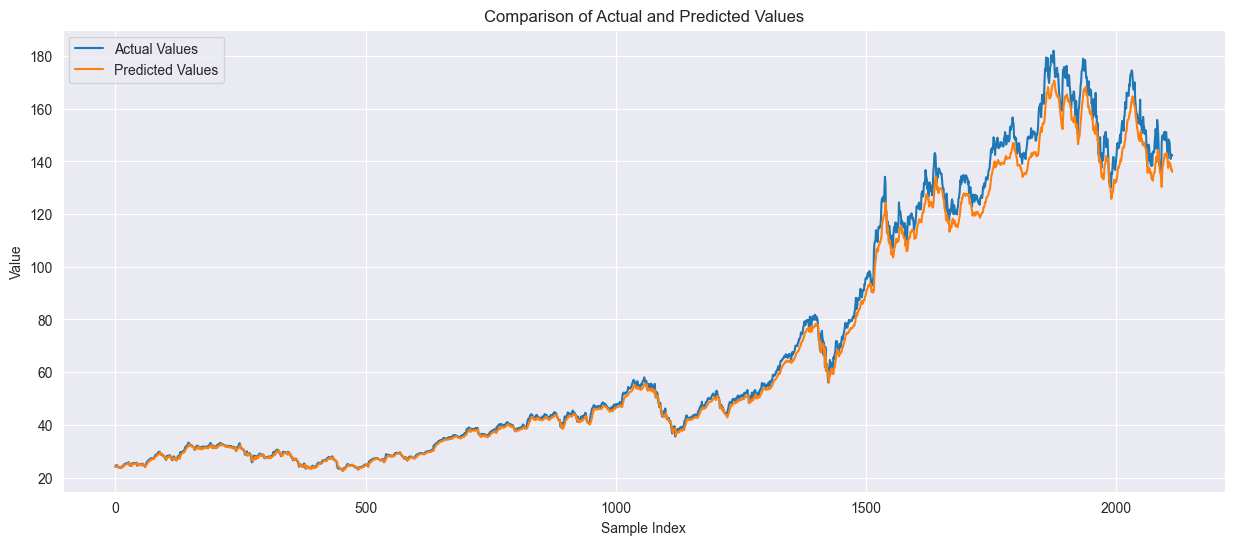

In [24]:
y_pred = model.predict(X_test)
# Plotting
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()